# **Прогностическая модель рисков беременных**

Описание данных:  

**Age:** Возраст беременной женщины в годах.  

**SystolicBP:** Систолическое АД - Верхнее значение артериального давления в мм рт.ст., еще один важный показатель во время беременности.  

**DiastolicBP:** Диастолическое АД  - Нижнее значение артериального давления в мм рт.ст., еще один важный показатель во время беременности.  

**BS:** Уровень глюкозы в крови, выраженный в молярной концентрации, ммоль/л.  

**HeartRate:** Частота сердечных сокращений: Нормальная частота сердечных сокращений в состоянии покоя в ударах в минуту.  

**Risk Level:** Уровень риска - Прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего признака.

## Обзор данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, f1_score

import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/таблица на 2 задание на дата сайенс.csv')

In [ ]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


В данных представлен столбец **BodyTemp** с параметром температуры тела. Судя по значениям, единицы измерения "Фаренгейт".  
Всего 1014 наблюдений с 7 признакима.  
Названия столбцов необходимо привести к принятому формату.



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
df.duplicated().sum()

np.int64(562)

In [ ]:
df = df.drop_duplicates()

Выявили 562 дубля, что больше половины данных.  
Чтобы избежать переобучения, искажения распределения и нечестной оценки дубли удаляем.

In [ ]:
df.isna().sum()

,0
Age,0
SystolicBP,0
DiastolicBP,0
BS,0
BodyTemp,0
HeartRate,0
RiskLevel,0


Пропусков в данных нет.

Приведем названия столбцов к принятому виду

In [ ]:
def camel_to_snake(column_name):
    # Вставляем подчеркивание перед заглавными буквами и переводим в нижний регистр
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', column_name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

df.columns = [camel_to_snake(col) for col in df.columns]
df.columns

Index(['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate',
       'risk_level'],
      dtype='object')

Посмотрим значения температуры, и преобразуем в привычные единицы измерения (Цельсия)

In [ ]:
df['body_temp'].unique()

array([ 98. , 100. , 102. , 101. , 103. ,  98.4,  99. ,  98.6])

In [ ]:
# преобразуем температуру в Цельсии
df['body_temp_celsius'] = round((df['body_temp'] - 32) * 5/9, 1)
df.head(1)

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,body_temp_celsius
0,25,130,80,15.0,98.0,86,high risk,36.7


Посмотрим значения уровней риска

In [ ]:
df['risk_level'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

В столбце указаны 3 варианта значений:  
'high risk' - высокий риск  
'low risk' - низкий риск  
'mid risk' - средний риск  

In [ ]:
df['risk_level'].value_counts()

,count
risk_level,
low risk,234
high risk,112
mid risk,106


Наблюдений со значением "низкий риск" в два раза больше, чем других.  
Необходимо будет ввести балансировку весов.

## Зависимости и распределения показателей

Посмотрим распределение всех признаков.

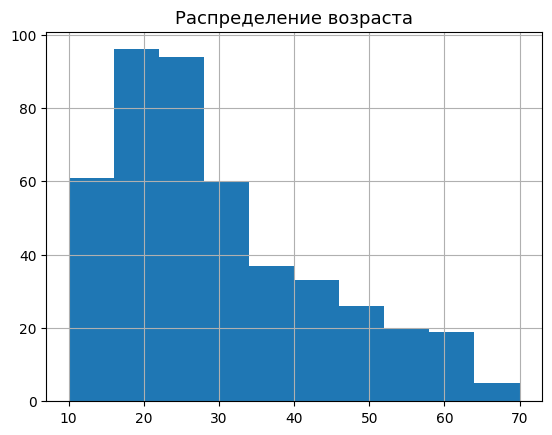

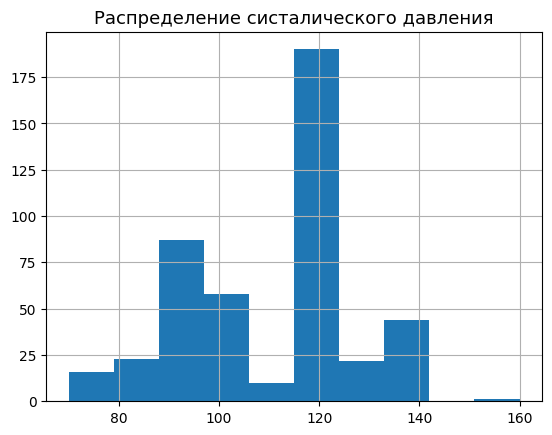

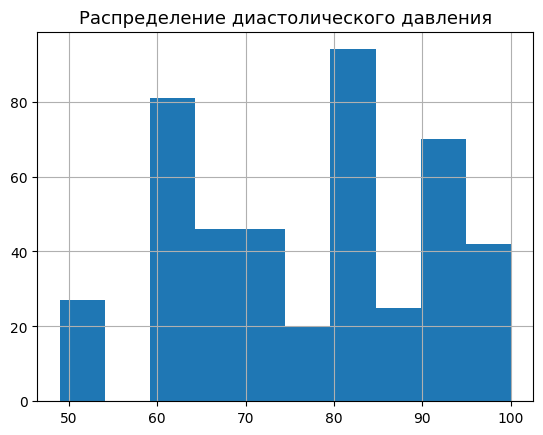

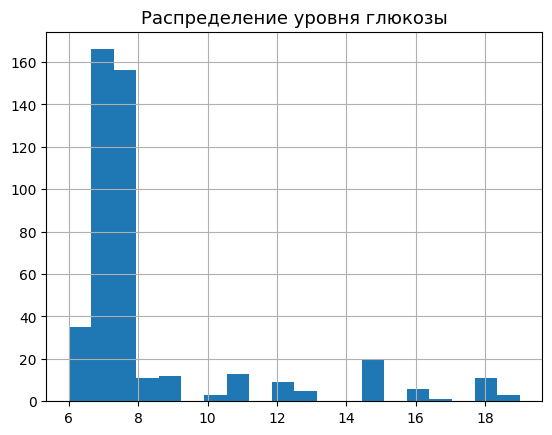

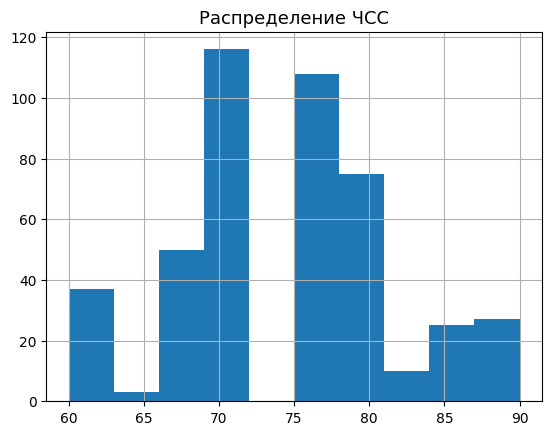

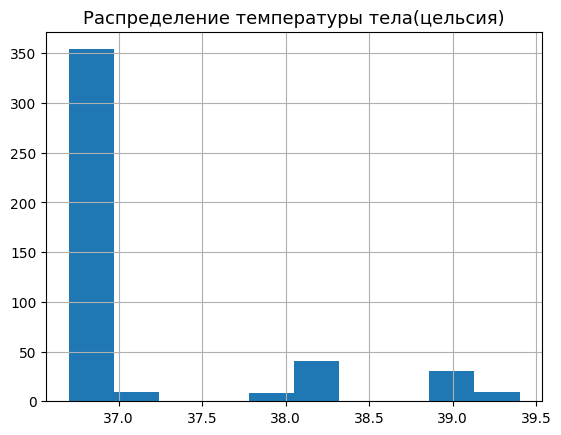

In [ ]:
df['age'].hist()
plt.title('Распределение возраста',fontsize=13)
plt.show()
df['systolic_bp'].hist()
plt.title('Распределение систалического давления',fontsize=13)
plt.show()
df['diastolic_bp'].hist()
plt.title('Распределение диастолического давления',fontsize=13)
plt.show()
df['bs'].hist(bins=20)
plt.title('Распределение уровня глюкозы',fontsize=13)
plt.show()
df['heart_rate'].hist()
plt.title('Распределение ЧСС',fontsize=13)
plt.show()
df['body_temp_celsius'].hist()
plt.title('Распределение температуры тела(цельсия)',fontsize=13)
plt.show()

**Возраст** распределен в диапазоне от 10 до 70 лет. Основная часть находиться в диапазоне от 16 до 28 лет.  

**Систалическое давление** от 70 до 160 мм рт.ст. Наиболее частые значения в районе 120, что соответствует норме.  


**Диастолическое давление** от 49 до 100 мм рт.ст. Основная часть находиться в диапазоне от 60 до 85, что тоже в пределах нормы.  

**Уровень глюкозы** в диапазоне от 6 до 19 ммоль/л. Что выбивается из нормы (3,3 - 5,5 ммоль/л), для беременных показатель не должен превышать 5,1 ммоль/л.  

**ЧСС** находится в диапазоне от 59 до 90 ударов в минуту, что соотвтетствует норме. Однако на гистограмме виден выброс - значение меньше 20 ударов в минуту. Посмотрим его отдельно.  

**Температура тела** находится в диапазоне от 36.7	до 39.4. У беременных может наблюдаться повышение температуры до 37.5, особенно в первый триместр. Все что выше, выходит за рамки нормы.


In [ ]:
df[df['heart_rate'] < 60]

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,body_temp_celsius
499,16,120,75,7.9,98.0,7,low risk,36.7


In [ ]:
df = df[df['heart_rate'] >=55]

ЧСС не может ровняться 7 ударам в минуту, так что исключим данное наблюдение.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,451.0,29.223947,13.768594,10.0,19.0,25.0,35.0,70.0
systolic_bp,451.0,110.532151,17.886574,70.0,90.0,120.0,120.0,160.0
diastolic_bp,451.0,75.419069,13.769838,49.0,65.0,80.0,87.0,100.0
bs,451.0,8.347162,2.832273,6.0,6.9,7.5,7.9,19.0
body_temp,451.0,98.694013,1.412086,98.0,98.0,98.0,98.0,103.0
heart_rate,451.0,74.097561,7.530045,60.0,70.0,76.0,80.0,90.0
body_temp_celsius,451.0,37.075166,0.766089,36.7,36.7,36.7,36.7,39.4


Мы видим что медианные значения и значения в третьем квартиле находяться в диапазонах нормы, и часто совпадают.

Зададим кодировку уровням риска и посмотрим корреляцию.

In [ ]:
# Задаем нужный порядок кодирования риска
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
class_names = ['low risk', 'mid risk', 'high risk']  # Порядок соответствует кодированию
# Применяем маппинг
df['risk_level_encoded'] = df['risk_level'].map(risk_mapping)

print("Соответствие кодов уровням риска:")
for level, code in risk_mapping.items():
    print(f"{code}: {level}")

Соответствие кодов уровням риска:
0: low risk
1: mid risk
2: high risk


In [ ]:
correlation_matrix = df[['risk_level_encoded','age', 'systolic_bp', 'diastolic_bp', 'bs', 'heart_rate', 'body_temp_celsius']].corr()
correlation_matrix

,risk_level_encoded,age,systolic_bp,diastolic_bp,bs,heart_rate,body_temp_celsius
risk_level_encoded,1.000000,0.181484,0.328777,0.254398,0.549064,0.181593,0.258249
age,0.181484,1.000000,0.377560,0.348137,0.376675,0.065055,-0.189524
systolic_bp,0.328777,0.377560,1.000000,0.790284,0.347837,0.003854,-0.207135
diastolic_bp,0.254398,0.348137,0.790284,1.000000,0.300421,-0.018462,-0.201222
bs,0.549064,0.376675,0.347837,0.300421,1.000000,0.143943,-0.042891
heart_rate,0.181593,0.065055,0.003854,-0.018462,0.143943,1.000000,0.083128
body_temp_celsius,0.258249,-0.189524,-0.207135,-0.201222,-0.042891,0.083128,1.000000


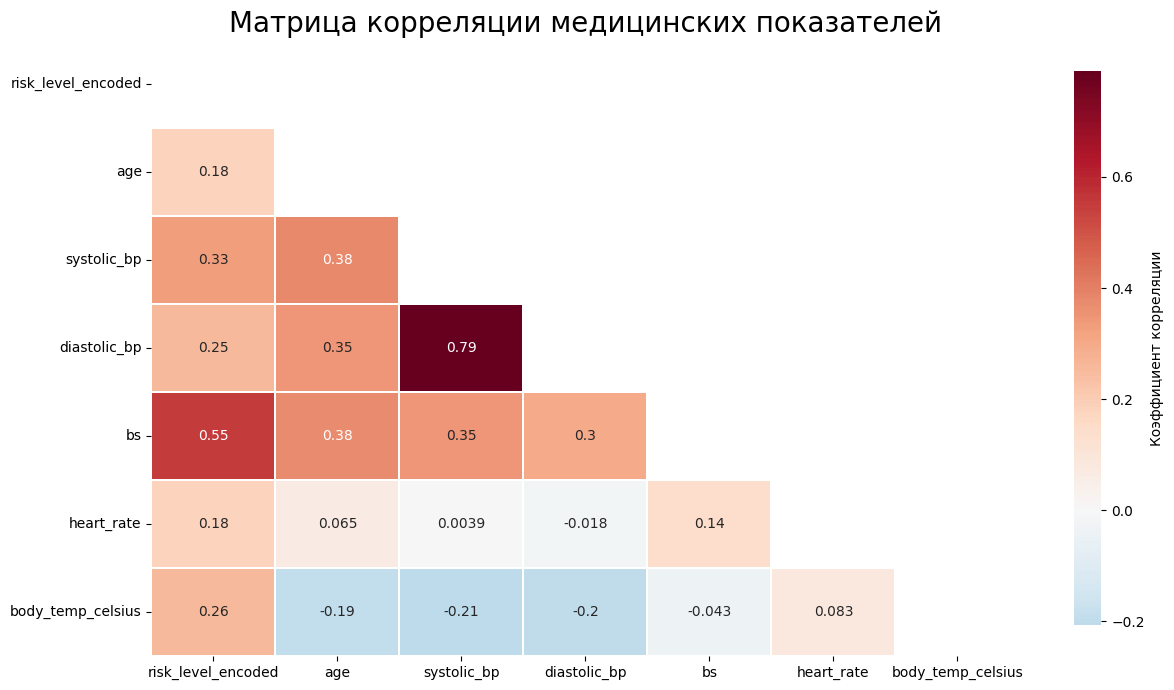

In [ ]:
matrix = np.triu(correlation_matrix)

plt.figure(figsize=(14,8))
sns.heatmap(correlation_matrix,
            annot = True,
            mask=matrix,
            linewidths=.3,
            cmap= 'RdBu_r',
            center=0,
            cbar_kws={'shrink': 0.9, 'label': 'Коэффициент корреляции'})#'inferno')
plt.title('Матрица корреляции медицинских показателей', fontsize = 20)
plt.show()

Наибольшая корреляция уровней риска с уровнем глюкозы.  
Так же видна высокая корреляция между систолическим и диастолическим давлением, что предсказуемо. Оба показателя важны для оценки риска беременности, удаление одного из признаков приведет к потере важной медицинской информации. Так что оставим оба показателя.

Рассмотрим распределение медицинских показателей по уровням риска.

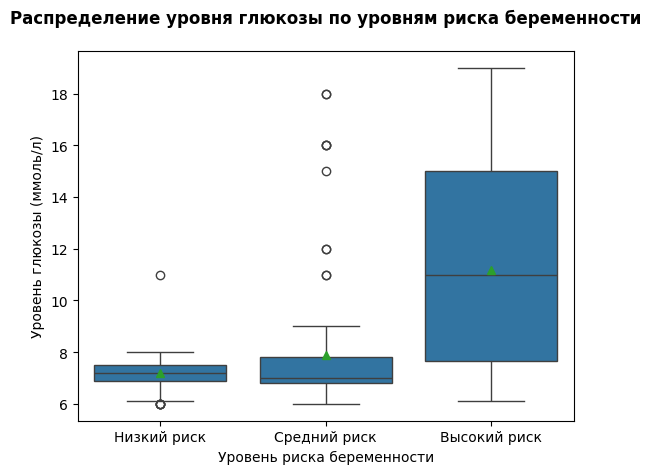

In [ ]:
sns.boxplot(x='risk_level_encoded', y='bs', data=df, showmeans=True)
plt.title('Распределение уровня глюкозы по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('Уровень глюкозы (ммоль/л)', fontsize=10)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Значения уровня глюкозы с низким и средним уровнем риска похожи. Основная масс значений находиться в диапазоне от 7 до 8 ммоль/л.  
У класса "высокий риск" значения глюкозы сильно высоки, в диапазоне от 8 до 15 ммоль/л, медиана и среднее значение совпадают  - 11 ммоль/л.


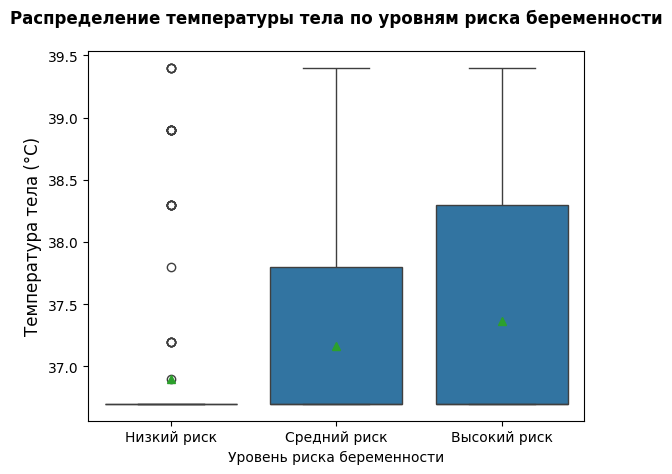

In [ ]:
sns.boxplot(x='risk_level_encoded', y='body_temp_celsius', data=df, showmeans=True)
plt.title('Распределение температуры тела по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('Температура тела (°C)', fontsize=12)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Температура тела для уровня "низкий риск" находится в пределаз нормы, и не превышает 37°C.  
Для "среднего риска" характерно повышение до 37,8°C., но есть наблюдения и выше 39°C.  
Для "высокого риска" характерно повышение до 38,3°C., но так же есть наблюдения и выше 39°C.


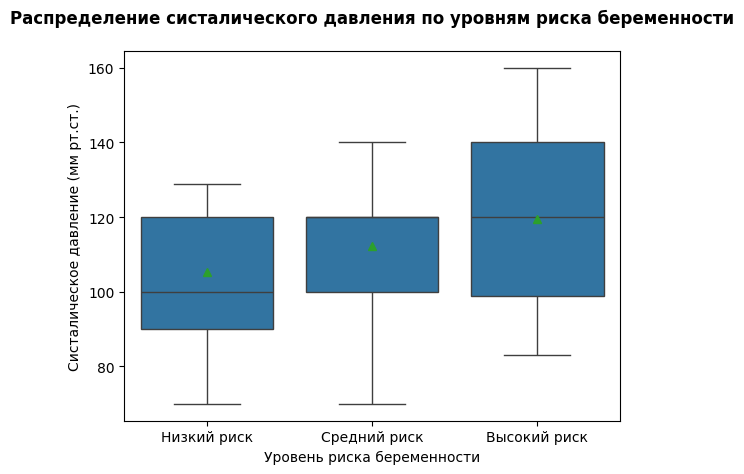

In [ ]:
sns.boxplot(x='risk_level_encoded', y='systolic_bp', data=df, showmeans=True)
plt.title('Распределение систалического давления по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('Систалическое давление (мм рт.ст.)', fontsize=10)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Значения систалического давления для "низкого уровня" характерны для гипотоников - медиана 100 мм рт.ст., среднее 105 мм рт.ст. Есть значения как сильно ниже - 70 мм рт.ст., так и выше - 130 мм рт.ст.  

Для "высокого риска" характерно повышение систалического давления до 140-160 мм рт.ст.

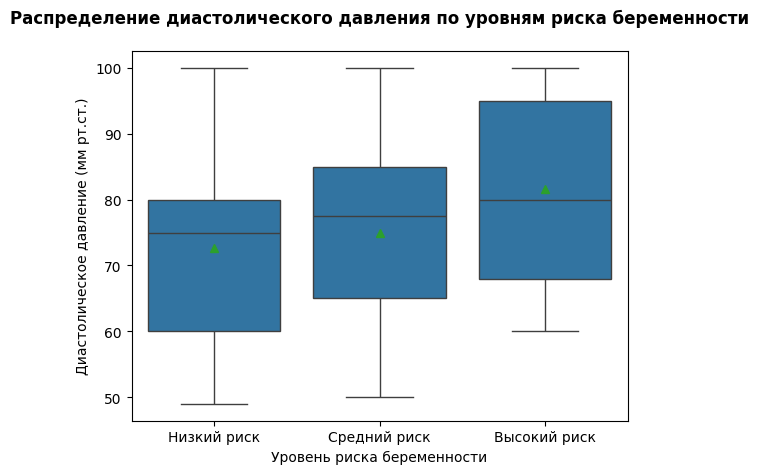

In [ ]:
sns.boxplot(x='risk_level_encoded', y='diastolic_bp', data=df, showmeans=True)
plt.title('Распределение диастолического давления по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('Диастолическое давление (мм рт.ст.)', fontsize=10)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Распределение диастолического давления по уровням риска похоже на распределение систалического.

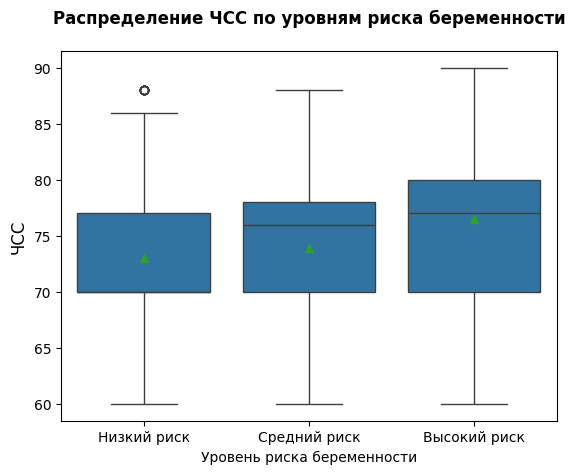

In [ ]:
sns.boxplot(x='risk_level_encoded', y='heart_rate', data=df, showmeans=True)
plt.title('Распределение ЧСС по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('ЧСС', fontsize=12)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Можно сказать, что у группы "высокий риск" ЧСС чуть увеличен по сравнению с другими группами, но все распределены в пределах нормы для беременных от 60 до 110 ударов в минуту.

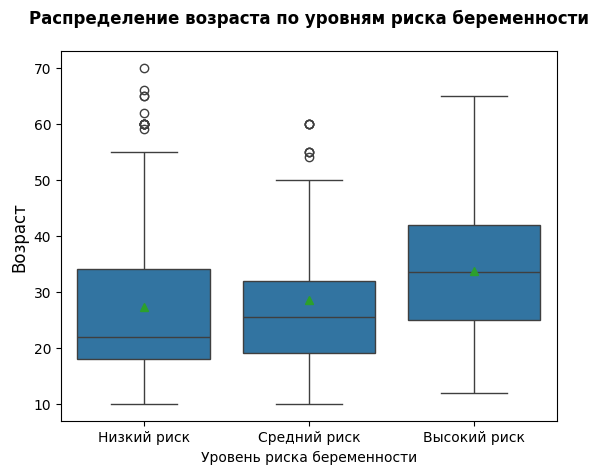

In [ ]:
sns.boxplot(x='risk_level_encoded', y='age', data=df, showmeans=True)
plt.title('Распределение возраста по уровням риска беременности',
          fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Уровень риска беременности', fontsize=10)
plt.ylabel('Возраст', fontsize=12)
# Добавляем подписи к уровням риска
risk_labels = ['Низкий риск', 'Средний риск', 'Высокий риск']
plt.xticks(ticks=[0, 1, 2], labels=risk_labels)
plt.show()

Риск для беременных несет и как более молодой возраст - меньше 16лет, так и более старший - больше 50 лет.  
Однако все эти случаи попадают в категорию "низкий риск".  
Основная часть наблюдений в группе "высокий риск" находиться в диапазоне 25-42 лет.

## Создание модели

In [ ]:
# Удаляем один из повторяющихся столбцов с температурой
df = df.drop('body_temp', axis=1)

# Разделение на признаки и целевую переменную
X = df[['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp_celsius', 'heart_rate']]
y = df['risk_level_encoded']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
# Подготавливаем данные
numeric_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

In [ ]:
# Модели для многоклассовой классификации
models = {
    'Random Forest': RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=3,            # Ограничить глубину
    min_samples_split=10
),
    'Gradient Boosting': GradientBoostingClassifier(
    random_state=42,
    n_estimators=50,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.7,          # Использовать только 70% данных для каждого дерева
    min_samples_split=20,   # Увеличить минимальное samples для split
),
    'Logistic Regression': LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    C=0.1,                  # Сильная регуляризация
    penalty='l2'            # L2 регуляризация
)
}

In [ ]:
# Обучение и оценка моделей
results = {}
print("\nОбучение моделей:")

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Кросс-валидация
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Обучение
    pipeline.fit(X_train, y_train)

    # Предсказания
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    results[name] = {
        'model': pipeline,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'test_auc': auc_score,
        'classification_report': classification_report(y_test, y_pred, target_names=class_names)
    }

    print(f"{name}: Accuracy = {accuracy:.3f}, AUC = {auc_score:.3f}")



Обучение моделей:
Random Forest: Accuracy = 0.692, AUC = 0.776
Gradient Boosting: Accuracy = 0.725, AUC = 0.782
Logistic Regression: Accuracy = 0.560, AUC = 0.755


In [ ]:
# Выбор лучшей модели
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")


Лучшая модель: Gradient Boosting


Выбираем Gradient Boosting:  

Accuracy = 72.5% - общая доля верных предсказаний  
AUC = 78.2% - способность различать классы (ранжирование)

**Важность признаков**

In [ ]:
# Важность признаков для лучшей модели
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    actual_features = best_model.named_steps['preprocessor'].transformers_[0][2]

    features_df = pd.DataFrame({
        'feature': actual_features,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    print("Важность признаков для Gradient Boosting:")
    print(features_df)

Важность признаков для Gradient Boosting:
             feature  importance
3                 bs    0.507937
1        systolic_bp    0.249179
4  body_temp_celsius    0.131785
0                age    0.052509
2       diastolic_bp    0.039594
5         heart_rate    0.018996


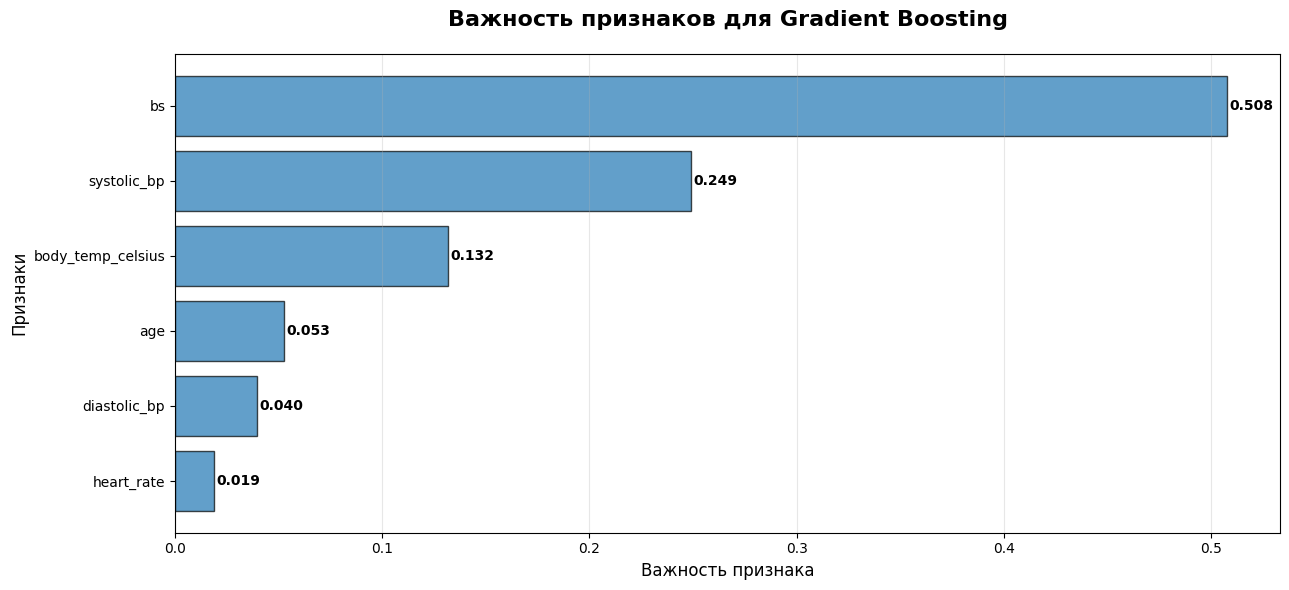

In [ ]:
# Важность признаков для лучшей модели (Gradient Boosting)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    actual_features = best_model.named_steps['preprocessor'].transformers_[0][2]

    features_df = features_df.sort_values(by= 'importance', ascending=True)
    plt.figure(figsize=(13, 6))

    # Создаем bar plot
    plt.barh(range(len(features_df)), features_df['importance'],
             alpha=0.7, edgecolor='black') #color='skyblue'

    # Добавляем значения на столбцы
    for i, v in enumerate(features_df['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center', fontweight='bold')

    plt.title('Важность признаков для Gradient Boosting',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Важность признака', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.yticks(range(len(features_df)), features_df['feature'])
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Оценка модели**

In [ ]:
# Вывод детального отчета
print(f"\nДетальный отчет для {best_model_name}:")
print(results[best_model_name]['classification_report'])


Детальный отчет для Gradient Boosting:
              precision    recall  f1-score   support

    low risk       0.73      0.96      0.83        47
    mid risk       0.67      0.19      0.30        21
   high risk       0.74      0.74      0.74        23

    accuracy                           0.73        91
   macro avg       0.71      0.63      0.62        91
weighted avg       0.72      0.73      0.68        91



**Класс "low risk" (низкий риск)** - 47 пациенток  
* Precision = 0.73 - Из всех, кого модель назвала "низкий риск", 73% действительно имеют низкий риск
* Recall = 0.96 - Модель нашла 96% всех реальных случаев низкого риска  
* F1 = 0.83 - Отличный баланс между точностью и полнотой


**Класс "mid risk" (средний риск)** - 21 пациентка  
* Precision = 0.67 - Когда модель говорит "средний риск", она права в 67% случаев
* Recall = 0.19 - Модель находит только 19% реальных случаев среднего риска  
* F1 = 0.30 - Низкое качество предсказаний  


**Класс "high risk" (высокий риск)** - 23 пациентки  
* Precision = 0.74 - Когда модель говорит "высокий риск", она права в 74% случаев  
* Recall = 0.74 - Модель находит 74% реальных случаев высокого риска  
* F1 = 0.74 - Хороший баланс

Хуже всего модель справляется с предсказанием "среднего риска".

In [ ]:
# Посмотрим, какие примеры mid risk неправильно классифицируются
y_test_pred = best_model.predict(X_test)
mid_risk_indices = y_test[y_test == 1].index
errors = X_test.loc[mid_risk_indices][y_test_pred != y_test]

print("Ошибочно классифицированные mid risk примеры:")
display(errors)
display(errors.describe())

# В какие классы их ошибочно относят
print("Ошибочные предсказания для mid risk:")
pd.crosstab(y_test[y_test == 1], y_test_pred[y_test == 1])

Ошибочно классифицированные mid risk примеры:


,age,systolic_bp,diastolic_bp,bs,body_temp_celsius,heart_rate
85,18,90,60,6.9,36.7,70
93,23,120,90,7.8,36.7,60
648,17,90,60,9.0,38.9,86
660,30,120,80,9.0,38.3,76
81,33,115,65,7.0,36.7,70
98,19,120,85,7.8,36.7,60
142,17,90,63,6.9,38.3,70
438,30,120,80,6.8,36.7,70
460,42,130,80,18.0,36.7,70
89,23,100,85,6.9,36.7,66


,age,systolic_bp,diastolic_bp,bs,body_temp_celsius,heart_rate
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,27.117647,103.529412,71.647059,8.164706,37.335294,73.352941
std,13.637643,18.007351,12.693213,2.702300,0.903425,8.753151
min,15.000000,70.000000,50.000000,6.000000,36.700000,60.000000
25%,17.000000,90.000000,60.000000,6.900000,36.700000,70.000000
50%,23.000000,100.000000,70.000000,7.500000,36.700000,70.000000
75%,30.000000,120.000000,80.000000,9.000000,38.300000,80.000000
max,60.000000,130.000000,90.000000,18.000000,38.900000,86.000000


Ошибочные предсказания для mid risk:


col_0,0,1,2
risk_level_encoded,,,
1,12,4,5


Возможно модель не учитывает отклонение показателей в нижнюю сторону от нормы ( снижение АД, и более молодой возраст).  
Так же при обзоре распределения признаков, было видно что уровень "средний риск" не сильно отличается от "низкого риска".  

**Рекомендации:**  
* Увеличить число наблюдений для обучения модели с пропорциональным распределением уровней риска.  
* Использовать принудительное распределение весов. Например:  
```
sample_weights = compute_sample_weight(
    class_weight={0: 1, 1: 3, 2: 1.5},
    y=y_train
)
```
* При возможности более четко разграничить присвоение уровня риска по медицинским показателям.


In [ ]:
# Функция для оценки модели на трейне и тесте
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names):
    """
    Полная оценка модели на трейне и тесте
    """
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Метрики
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')

    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    # AUC (для многоклассовой)
    train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
    test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')

    # Вывод метрик
    print("МЕТРИКИ МОДЕЛИ")
    print("=" * 60)
    print(f"{'Метрика':<20} {'Трейнинг':<12} {'Тест':<12} {'Разница':<12}")
    print("=" * 60)
    print(f"{'Accuracy':<20} {train_accuracy:.4f}      {test_accuracy:.4f}      {abs(train_accuracy - test_accuracy):.4f}")
    print(f"{'Precision':<20} {train_precision:.4f}      {test_precision:.4f}      {abs(train_precision - test_precision):.4f}")
    print(f"{'Recall':<20} {train_recall:.4f}      {test_recall:.4f}      {abs(train_recall - test_recall):.4f}")
    print(f"{'F1-Score':<20} {train_f1:.4f}      {test_f1:.4f}      {abs(train_f1 - test_f1):.4f}")
    print(f"{'AUC':<20} {train_auc:.4f}      {test_auc:.4f}      {abs(train_auc - test_auc):.4f}")
    print("=" * 60)

    # Детальные отчеты
    print("\nДЕТАЛЬНЫЙ ОТЧЕТ НА ТРЕЙНЕ:")
    print(classification_report(y_train, y_train_pred, target_names=class_names))

    print("\nДЕТАЛЬНЫЙ ОТЧЕТ НА ТЕСТЕ:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Матрицы ошибок
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Трейн матрица
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=class_names,
                yticklabels=class_names)
    axes[0].set_title('Матрица ошибок - Трейн\n(Accuracy: {:.3f})'.format(train_accuracy))
    axes[0].set_xlabel('Предсказанные')
    axes[0].set_ylabel('Фактические')

    # Тест матрица
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', ax=axes[1],
                xticklabels=class_names,
                yticklabels=class_names)
    axes[1].set_title('Матрица ошибок - Тест\n(Accuracy: {:.3f})'.format(test_accuracy))
    axes[1].set_xlabel('Предсказанные')
    axes[1].set_ylabel('Фактические')

    plt.tight_layout()
    plt.show()

    # Анализ переобучения
    print("\n АНАЛИЗ ПЕРЕОБУЧЕНИЯ:")
    accuracy_diff = abs(train_accuracy - test_accuracy)
    if accuracy_diff > 0.1:
        print(f"⚠️  Возможно переобучение! Разница accuracy: {accuracy_diff:.3f}")
    elif accuracy_diff > 0.05:
        print(f"📊 Умеренная разница: {accuracy_diff:.3f}")
    else:
        print(f"✅ Хорошая обобщающая способность! Разница: {accuracy_diff:.3f}")

    return {
        'train_metrics': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1,
            'auc': train_auc
        },
        'test_metrics': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc
        }
    }

ПОЛНАЯ ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ
МЕТРИКИ МОДЕЛИ
Метрика              Трейнинг     Тест         Разница     
Accuracy             0.7667      0.7253      0.0414
Precision            0.7797      0.7155      0.0642
Recall               0.7667      0.7253      0.0414
F1-Score             0.7289      0.6816      0.0473
AUC                  0.8973      0.7819      0.1154

ДЕТАЛЬНЫЙ ОТЧЕТ НА ТРЕЙНЕ:
              precision    recall  f1-score   support

    low risk       0.73      0.98      0.84       186
    mid risk       0.81      0.25      0.38        85
   high risk       0.85      0.82      0.83        89

    accuracy                           0.77       360
   macro avg       0.80      0.68      0.68       360
weighted avg       0.78      0.77      0.73       360


ДЕТАЛЬНЫЙ ОТЧЕТ НА ТЕСТЕ:
              precision    recall  f1-score   support

    low risk       0.73      0.96      0.83        47
    mid risk       0.67      0.19      0.30        21
   high risk       0.74      0.74     

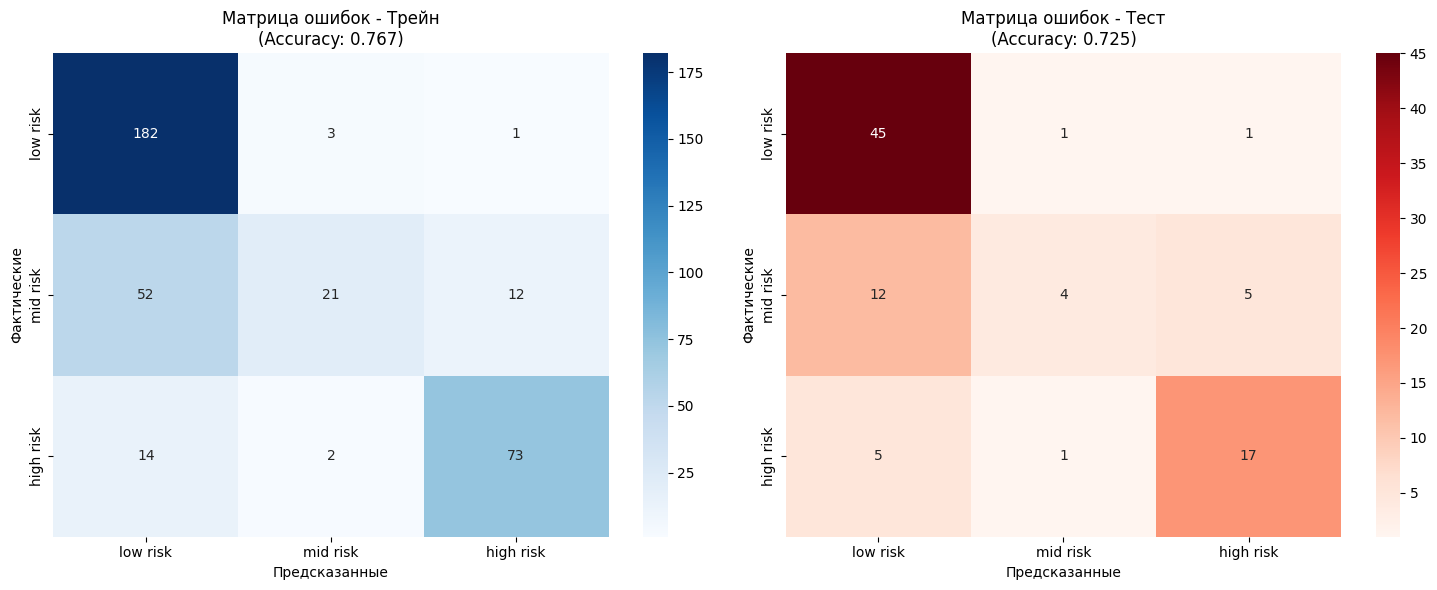


 АНАЛИЗ ПЕРЕОБУЧЕНИЯ:
✅ Хорошая обобщающая способность! Разница: 0.041


In [ ]:
# Оценка лучшей модели на трейне и тесте
print("ПОЛНАЯ ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ")
print("="*60)
metrics_results = evaluate_model(best_model, X_train, y_train, X_test, y_test, class_names)


## Общие выводы и выбор модели

###Выбор модели

Выбрана модель: Gradient Boosting (Градиентный бустинг)

Причины выбора:  

Наивысшая точность: 72.5% против 69.2% у Random Forest и 56.0% у Logistic Regression

Лучшая способность различать классы: AUC = 78.2%

Стабильная производительность на тестовых данных

###Ключевые показатели модели

**Общая эффективность:**  
Точность (Accuracy): 72.5% - доля верных предсказаний  
AUC-ROC: 78.2% - способность модели различать классы риска  

Качество предсказаний по классам:
- **Низкий риск (47 пациенток):**

  Точность предсказания: 73% - когда модель говорит "низкий риск", она права в 73% случаев

  Полнота: 96% - модель находит 96% всех реальных случаев низкого риска

  F1-мера: 83% - отличный баланс между точностью и полнотой

- **Высокий риск (23 пациентки):**

  Точность предсказания: 74% - когда модель говорит "высокий риск", она права в 74% случаев

  Полнота: 74% - модель находит 74% реальных случаев высокого риска

  F1-мера: 74% - хороший баланс

- **Средний риск (21 пациентка):**

  Точность предсказания: 67% - когда модель говорит "средний риск", она права в 67% случаев

  Полнота: 19% - модель находит только 19% реальных случаев среднего риска

  F1-мера: 30% - низкое качество предсказаний

###Важные медицинские показатели
**Наиболее значимые признаки:**

- Уровень сахара в крови (BS) - 50.8% важности

- Систолическое давление - 24.9% важности

- Температура тела - 13.2% важности

- Возраст - 5.3% важности

- Диастолическое давление - 4.0% важности

- Частота сердечных сокращений - 1.9% важности  

### Выявленные проблемы
Основная проблема: Модель плохо определяет средний риск

Низкая полнота (19%) - пропускает 81% реальных случаев среднего риска

Возможные причины: недостаточное различие показателей между низким и средним риском

### Рекомендации по улучшению
- Увеличить объем данных с пропорциональным распределением по уровням риска

- Применить взвешивание классов для улучшения предсказания среднего риска

- Уточнить медицинские критерии разграничения уровней риска

- Рассмотреть дополнительные показатели для лучшего разделения классов

### Заключение
Модель Gradient Boosting демонстрирует хорошую общую эффективность (72.5% точности) и отлично справляется с определением низкого и высокого риска. Требуется доработка в области предсказания среднего риска для повышения клинической ценности модели.

